### Imports

In [ ]:
import numpy as np
from numpy import nan
import pandas as pd
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn_pandas import CategoricalImputer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore',FutureWarning)



### Removing <i>acci_id</i>

In [ ]:
#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents.csv")
    
df1 = df.drop("acci_id",axis=1)
    
#Write to new CSV
df1.to_csv("Traffic_Incidents_1.csv", encoding='utf-8', index=False)

### Translating <i>acci_name</i>

In [ ]:
def translate(to_translate):
    """Translates all the values from the passed list into a English

    Args:
        to_translate (list): list of values to be translated

    Returns:
        translated: list of translated values
    """
    #Initilize translator from googletrans library (whihc uses Google Translate API)
    translator = Translator()

    translated = []
    counter = 1

    for s in to_translate:
        print(f'Translating {counter}/{len(to_translate)}')
        counter +=1
        #Translate the text and append it to result list
        translation = translator.translate(s,src='ar',target='en')
        translated.append(translation.text)
    return translated

#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents_1.csv")

#Get list of unique values in acci_name column
original = list(df.acci_name.unique())

#Replace the original values in the dataframe with the translated values using the translate function
print("Translating dataframe...")
df1 = df.replace(original,translate(original))

#Write to new CSV file
print("Writing to csv file...")
df1.to_csv("Traffic_Incidents_2.csv", encoding='utf-8', index=False)

### Splitting <i>acci_name</i>

In [3]:
#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents_2.csv")

#Split column based on '-' delimeter
df[['acci_desc','acci_severity']] = df.acci_name.str.split('-',expand=True) 

#Remove old column
df1 = df.drop("acci_name",axis=1)

#Strip the description and severity
df1['acci_desc'] = df1['acci_desc'].str.strip()
df1['acci_severity'] = df1['acci_severity'].str.strip()

#Write to new CSV
df1.to_csv("Traffic_Incidents_3.csv", encoding='utf-8', index=False)

### Standardizing  <i>acci_severity</i>

In [5]:
#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents_3.csv")

#Get list of unique values in acci_severity column
original = list(df.acci_severity.unique())

#Change all values that aren't 'simple' or 'serious' into 'serious'. Keep missing severities the same.
original.remove('simple')
original.remove('serious')
original.remove(nan)

df1 = df.replace(original,'serious')

#Write to new CSV file
df1.to_csv("Traffic_Incidents_4.csv", encoding='utf-8', index=False)

### Identify Null Rows

In [ ]:
#checking how many rows have missing severity
df = pd.read_csv("Traffic_Incidents_4.csv")

#Check how many rows have emprt severities (True means no severity)
df1 = df['acci_severity'].isnull()
count = df1[df1 == True].value_counts()[True]
print(f"There are {count} inccidents with missing severities.")

#Check the descriptions of the missing severity incidents
null_rows = df[df.isnull().any(axis=1)]
print(null_rows["acci_desc"].value_counts())


There are 3414 inccidents with missing severities.
acci_desc
Illegal vehicles                                                                   3133
One or more people crossing from a place not designated for pedestrian crossing     217
Vehicle fire while driving                                                           64
Name: count, dtype: int64


### Removing Unwanted Incidents

In [6]:
#read dataframe
df = pd.read_csv("Traffic_Incidents_4.csv")
#create a set of all incident descriptions with a null severity except vehicle fire while driving
unwanted = set(null_rows['acci_desc'])
unwanted.remove('Vehicle fire while driving')

#remove the rows with these descriptions 
for desc in unwanted:
    df = df[(df['acci_desc'] != desc)]
df.to_csv("Traffic_Incidents_5.csv", encoding='utf-8', index=False)

### Splitting Date and Time

In [7]:
#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents_5.csv")

#Split column based on ' ' delimeter
df[['acci_date','acci_time']] = df.acci_time.str.split(' ',expand=True) 

#Write to new CSV
df.to_csv("Traffic_Incidents_6.csv", encoding='utf-8', index=False)

### Standardizing Date and Time

In [8]:
#Read CSV data into panda dataframe
df = pd.read_csv("Traffic_Incidents_6.csv")

#Convert the format of acci_date into datetime. This step is not neccessary but is for standarizing the format of dates
df['acci_date'] = pd.to_datetime(df['acci_date'],dayfirst=True)

#Write to a new CSV file
df.to_csv("Traffic_Incidents_7.csv", encoding='utf-8', index=False)

### Predicting Missing Severities

#### Find Severity Probability

In [9]:
def severity_probability(data):
    df = pd.read_csv(data)
    # Find counts of each severity
    df1 = df["acci_severity"].value_counts()

    # Calculate the probability
    prob_simple = (df1['simple']/(df1['simple'] + df1['serious']))
    prob_serious = (df1['serious']/(df1['simple'] + df1['serious']))

    #print the results
    print(f"The probability of simple severity is {prob_simple * 100:.2f}%")
    print(f"The probability of serious severity is {prob_serious * 100:.2f}%")
    return [round(prob_simple,2),round(prob_serious,2)]
severity_probability("Traffic_Incidents_7.csv")

The probability of simple severity is 91.86%
The probability of serious severity is 8.14%


[0.92, 0.08]

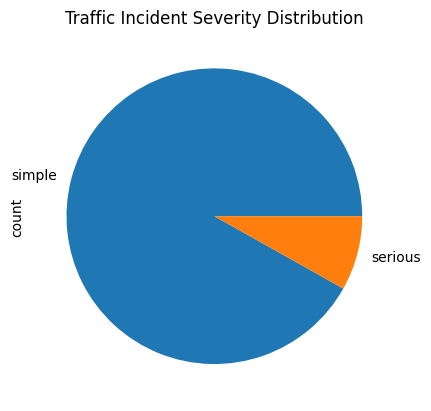

In [33]:
df = pd.read_csv("Traffic_Incidents_7.csv")
#visualize the probability
df['acci_severity'].value_counts().plot(kind = 'pie')
plt.title("Traffic Incident Severity Distribution")
plt.savefig("Traffic_Incident_Severity_Distribution.png")

#### Method 1: Using a Categorical Imputer

In [44]:
df = pd.read_csv("Traffic_Incidents_7.csv",parse_dates=['acci_time','acci_date'])

imputer = CategoricalImputer()

#feed the dataset to the imputer and it will predict the null severities
predictions = imputer.fit_transform(df['acci_severity'])
df['acci_severity'] = predictions
df.to_csv("Traffic_Incidents_imputer.csv", encoding='utf-8', index=False)

acci_severity
serious    68
simple     64
Name: count, dtype: int64


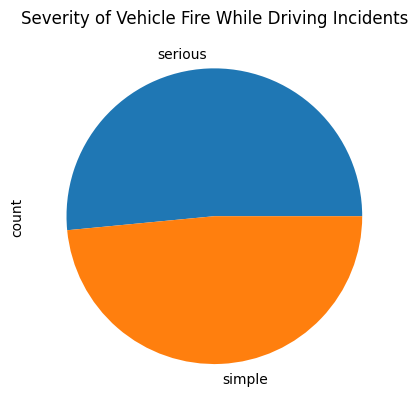

In [35]:
df = pd.read_csv("Traffic_Incidents_imputer.csv")
df1 = df['acci_severity'][df['acci_desc'] == 'Vehicle fire while driving'].value_counts()

#the imputer predictions resulted in all the null values being predicted as simple
print(df1)
df1.plot(kind='pie')
plt.title("Severity of Vehicle Fire While Driving Incidents")
plt.savefig("Severity_of_Vehicle_Fire_While_Driving_Incidents.png")

As we can see, the Categorical Imputer predicted all the null values as being simple, which seemed inaccurate as all of the previously rated incidents with the same description were labelled as "Serious". Therefore we decided to try using other methods

#### Method 2: Using Logistic Regression

We decided to use logistic regression as it's better for predicting binary labels such as severity, however the issue here is that scikit learn's logistic regression model can only take integers and floats, meaning that our other attributes won't be helpful. We attempted to use methods like one hot encoding to bypass this limitation, however with a dataset of this size and attributes having a large domain, our machine was running out of memory before completing the model.

This meant we had to drop all the attributes that were datetime or string objects.

In [45]:
df = pd.read_csv("Traffic_Incidents_7.csv",parse_dates=['acci_time','acci_date'])

#split the dataset into training and testing sets
train = df[df['acci_severity'].isnull()==False]
test = df[df['acci_severity'].isnull()==True]

#drop any column that doesn't contain floats or int values as sklearn models do not support other types
X_train = train.drop(['acci_time','acci_severity','acci_desc','acci_date'],axis=1)
X_test = test.drop(['acci_time','acci_severity','acci_desc','acci_date'],axis=1)
Y_train = train['acci_severity']
Y_test = test['acci_severity']

# fit the model with data to train it
model = LogisticRegression()
model.fit(X_train, Y_train)

#make and print the predictions
predictions = model.predict(X_test)
print(predictions)


['simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple']


As we can see, we got the same result as the categorical imputer, meaning that we did not improve our predictions yet.

#### Method 3: Improving Logistic Regression

To try and improve our logistic regression model slightly, we tried to transform the date and time into timestamps, which can be used by the model.

In [46]:
df = pd.read_csv("Traffic_Incidents_7.csv",parse_dates=['acci_time','acci_date'])

#transform the time and date into floats
df['acci_time'] = df['acci_time'].apply(lambda x: x.timestamp())
df['acci_date'] = df['acci_date'].apply(lambda x: x.timestamp())

#split the dataset into training and testing sets
train = df[df['acci_severity'].isnull()==False]
test = df[df['acci_severity'].isnull()==True]

#drop any column that doesn't contain floats or int values as sklearn models do not support other types
X_train = train.drop(['acci_severity','acci_desc'],axis=1)
X_test = test.drop(['acci_severity','acci_desc'],axis=1)
Y_train = train['acci_severity']

# fit the model with data to train it
model = LogisticRegression()
model.fit(X_train, Y_train)

#make and print the predictions
predictions = model.predict(X_test)
print(predictions)

['simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple'
 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple' 'simple']


Once again, all predictions were "simple", meaning that the model is not accurate enough.

#### Method 4: Creating a Random Forest

To try and see if any associations between the attributes would overpower the large skew of samples towards simple accidents, we used RapidMiner to create a random forest that can be seen in <b>severity_forest.rmp</b>, and the output can be seen in "Traffic_Incidents_RandForest.csv".

The result had all the severities for this type of incident be set to "serious" all of the 64 records having a confidence over 0.9

While this method did not exactly draw unexpected outcomes, it's still considered more accurate than our previous attempts, therefore we will be proceeding with these results.

In [76]:
df = pd.read_csv("Traffic_Incidents_7.csv",)
#fill all null severities with the value serious
df["acci_severity"].fillna("serious", inplace = True)
df.to_csv("Traffic_Incidents_8.csv", encoding='utf-8', index=False)

### Correcting Incorrect Records
While exploring our data we identified a record with x and y coordinates set to 0, which is far outside of coordinates in which Dubai resides. To fill this record, we will be using the mean (or average) of all the other coordinates

In [ ]:
df = pd.read_csv("Traffic_Incidents_8.csv",parse_dates=['acci_date'])
# Find the mean of the columns excluding the incorrect record
mean_x = df.loc[df['acci_x'] != 0, 'acci_x'].mean()
mean_y = df.loc[df['acci_y'] != 0, 'acci_y'].mean()

print(f"Calculated coordinates: ({mean_y},{mean_x})")
# Replace 0 values with the calculated means
df.loc[df['acci_x'] == 0, 'acci_x'] = mean_x
df.loc[df['acci_y'] == 0, 'acci_y'] = mean_y

#make all years 2024
filter = df["acci_date"].apply(lambda x: x.replace(year=2024))
df["acci_date"] = np.where(df["acci_date"].dt.year == 2023, filter, df["acci_date"])
df.to_csv("Traffic_Incidents_9.csv", encoding='utf-8', index=False)

Calculated coordinates: (55.29489228735156,25.152824680363487)


## Visualizing the Dataset

### Plotting The Points to Create a Map-Like Model

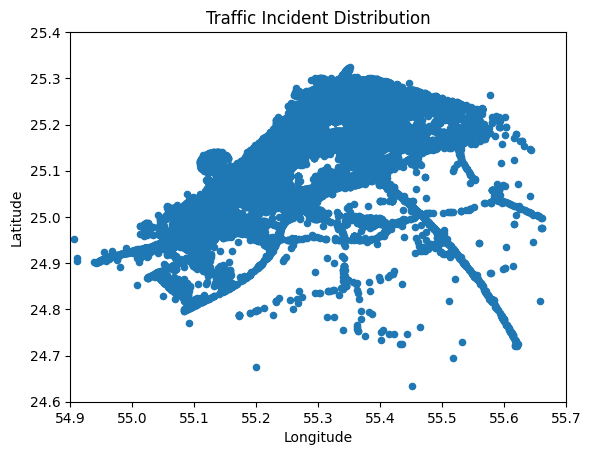

In [76]:
df = pd.read_csv("Traffic_Incidents_9.csv")
df.plot(kind = 'scatter', x = 'acci_y', y = 'acci_x', xlim=(54.9, 55.7), ylim=(24.6, 25.4))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Incident Distribution")
plt.savefig("Incident_Distribution_Map.png")

### Graphing Incidents Throughout Each Month

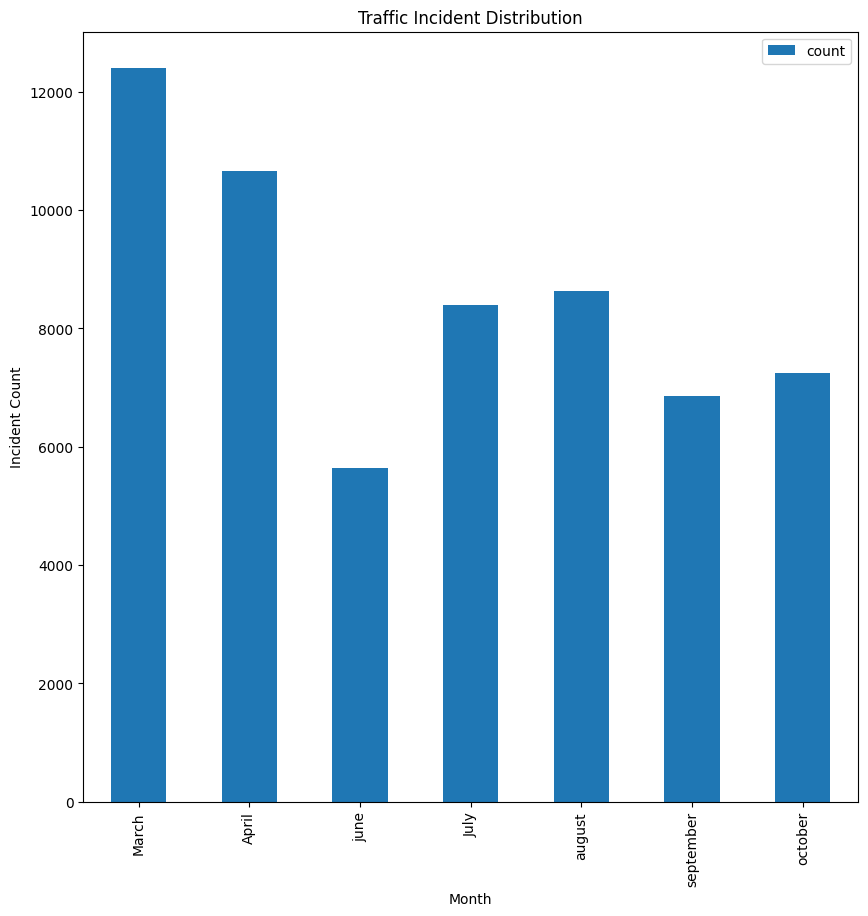

In [77]:
#read in dataframe
df = pd.read_csv("Traffic_Incidents_9.csv",parse_dates=['acci_date'])
df['Month'] = df['acci_date'].dt.month
df.set_index('Month',inplace=True)

#group by months and change months into nonminal values
grouped = df.groupby('Month').size().to_frame('count').reset_index()
grouped['Month'] = ['March', 'April', "june" , "July", "august", "september", "october"]

grouped.plot(kind='bar', x='Month', y='count',figsize=(10, 10))
plt.xlabel("Month")
plt.ylabel("Incident Count")
plt.title("Traffic Incident Distribution")
plt.savefig("Incident_Distribution_By_Month.png")

### Distribution of Updated Severities

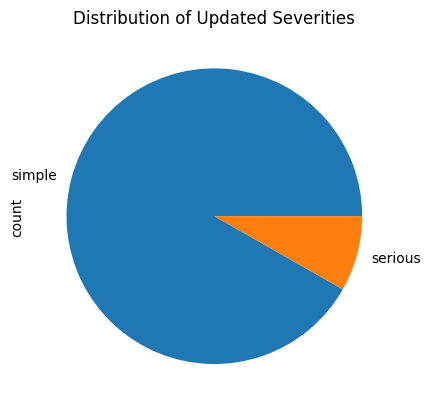

In [78]:
df = pd.read_csv("Traffic_Incidents_9.csv")
#visualize the probability
df['acci_severity'].value_counts().plot(kind = 'pie')
plt.title("Distribution of Updated Severities")
plt.savefig("Distribution_of_Updated_Severities.png")

## Experimental Analysis

### Outlier Analysis

#### Creating a K-Distance Graph to Choose Epsilon

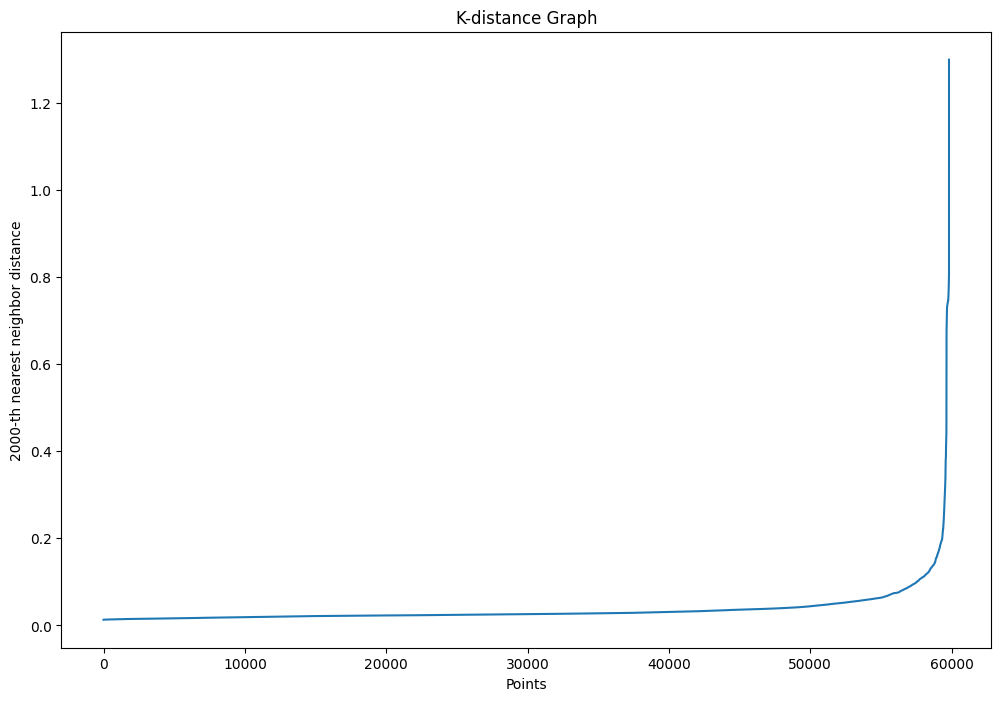

In [79]:
df = pd.read_csv("Traffic_Incidents_9.csv")
df1=df[['acci_x','acci_y']]

#calculate distance of k'th nearest neighbor
k=2000
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(df1)
distances, _ = neigh.kneighbors(df1)
#sort the distances
distances = np.sort(distances[:, k-1])
#plot
plt.figure(figsize=(12, 8))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.savefig("K-distance_graph.png")
plt.show()

#### Using DBSCAN to Identify Outliers

DBSCAN identified 5 outliers


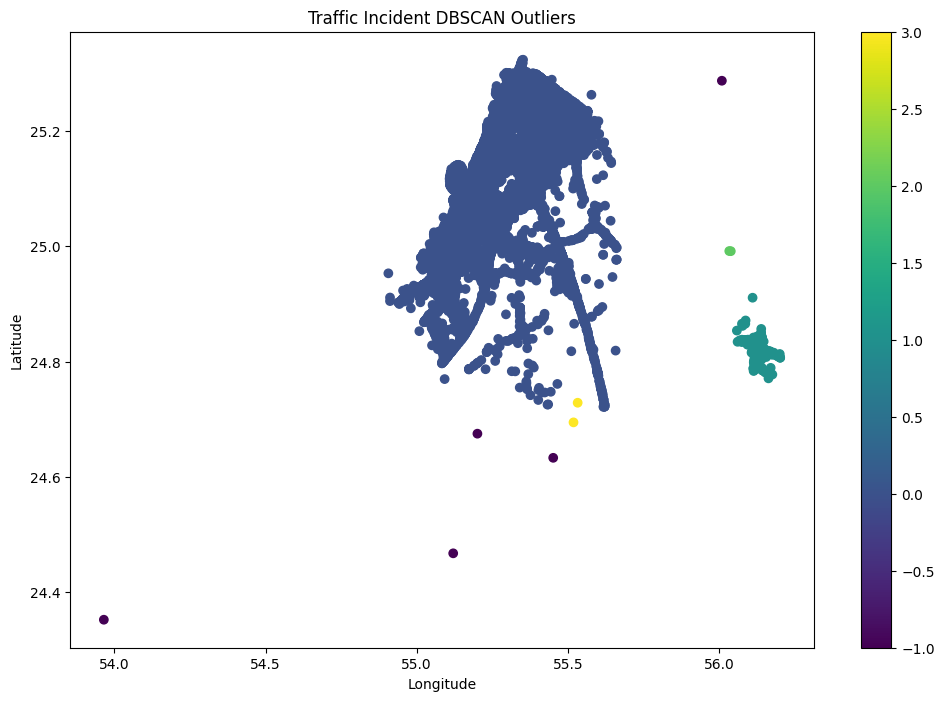

In [80]:
df = pd.read_csv("Traffic_Incidents_9.csv")
# create the training set
train = df[['acci_x','acci_y']]

# Most satisfactory parameters for outliers based on elbow method
dbscan = DBSCAN(eps=0.07, min_samples=2)
clusters = dbscan.fit_predict(train)

#plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(train['acci_y'], train['acci_x'], c=clusters,)
print(f"DBSCAN identified {list(clusters).count(-1)} outliers")
plt.colorbar(scatter)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Incident DBSCAN Outliers")
plt.savefig("Traffic_Incident_DBSCAN_Outliers.png")
plt.show()

#### Removing Outliers


In [81]:
df = pd.read_csv("Traffic_Incidents_9.csv")
df = df[(df['acci_y'] >= 54.5) & (df['acci_y'] <= 56) ]
df.to_csv("Traffic_Incidents_10.csv", encoding='utf-8', index=False)

#### Using DBSCAN to Identify Incident Clusters

DBSCAN identified 88 clusters


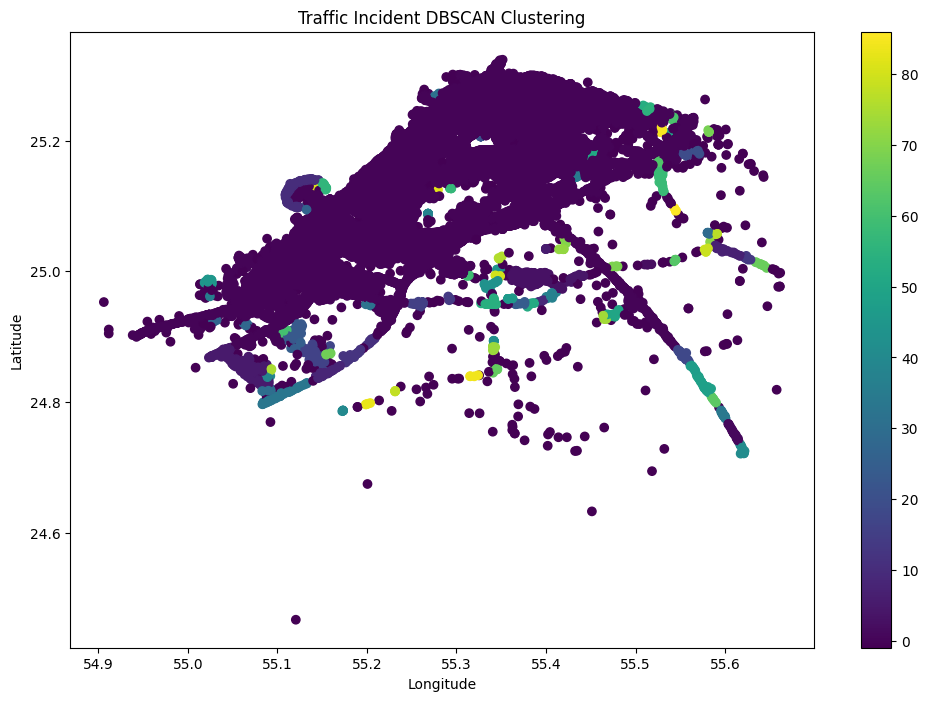

In [82]:
df = pd.read_csv("Traffic_Incidents_10.csv")
# create the training set
train = df[['acci_x','acci_y']]

# Most satisfactory parameters based on our testing
dbscan = DBSCAN(eps=0.005, min_samples=4 )
clusters = dbscan.fit_predict(train)

#plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(train['acci_y'], train['acci_x'], c=clusters)
print(f"DBSCAN identified {len(set(clusters))} clusters")
plt.colorbar(scatter)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Incident DBSCAN Clustering")
plt.savefig("Traffic_Incident_DBSCAN_Clustering.png")
plt.show()

### Creating Future Forecasts

#### Filling in the Month of May 2024

       Month    count
0      March  12358.0
1      April  10624.0
7        May   8123.5
2       June   5623.0
3       July   8361.0
4     August   8607.0
5  September   6838.0
6    October   7228.0


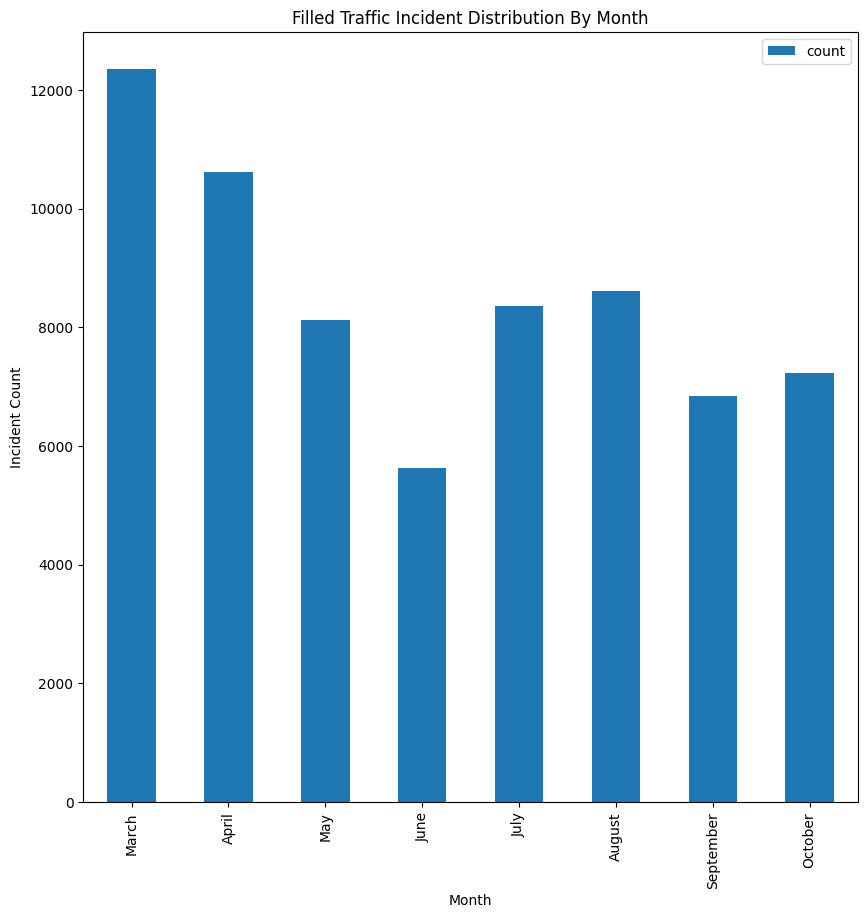

In [83]:
#Read in dataframe and group into months
df = pd.read_csv("Traffic_Incidents_10.csv",parse_dates=['acci_date'])
df['Month'] = df['acci_date'].dt.month
grouped = df.groupby('Month').size().to_frame('count').reset_index()

#Add a record for the month of May and sort the dataframe by month
grouped = pd.concat([grouped,pd.DataFrame({"Month":[5],'count':[nan]})], ignore_index=True)
grouped = grouped.sort_values(by='Month')

#Use linear interpolation to predict the number of incidents in the month of may
grouped = grouped.interpolate(method='linear')
grouped['Month'] = ['March', 'April', 'May', "June" , "July", "August", "September", "October"]
print(grouped)
#Plot

grouped.plot(kind='bar', x='Month', y='count',figsize=(10, 10))
plt.xlabel("Month")
plt.ylabel("Incident Count")
plt.title("Filled Traffic Incident Distribution By Month")
plt.savefig("Filled_Incident_Distribution_By_Month.png")
plt.show()
grouped.to_csv("Monthly_Traffic_Incidents_Filled.csv", encoding='utf-8', index=False)

#### Creating Forecasts for Upcoming Months With a Seasonality of 12

ADF Statistic: -3.0381105175445473
p-value: 0.03148540178230415
Stationary


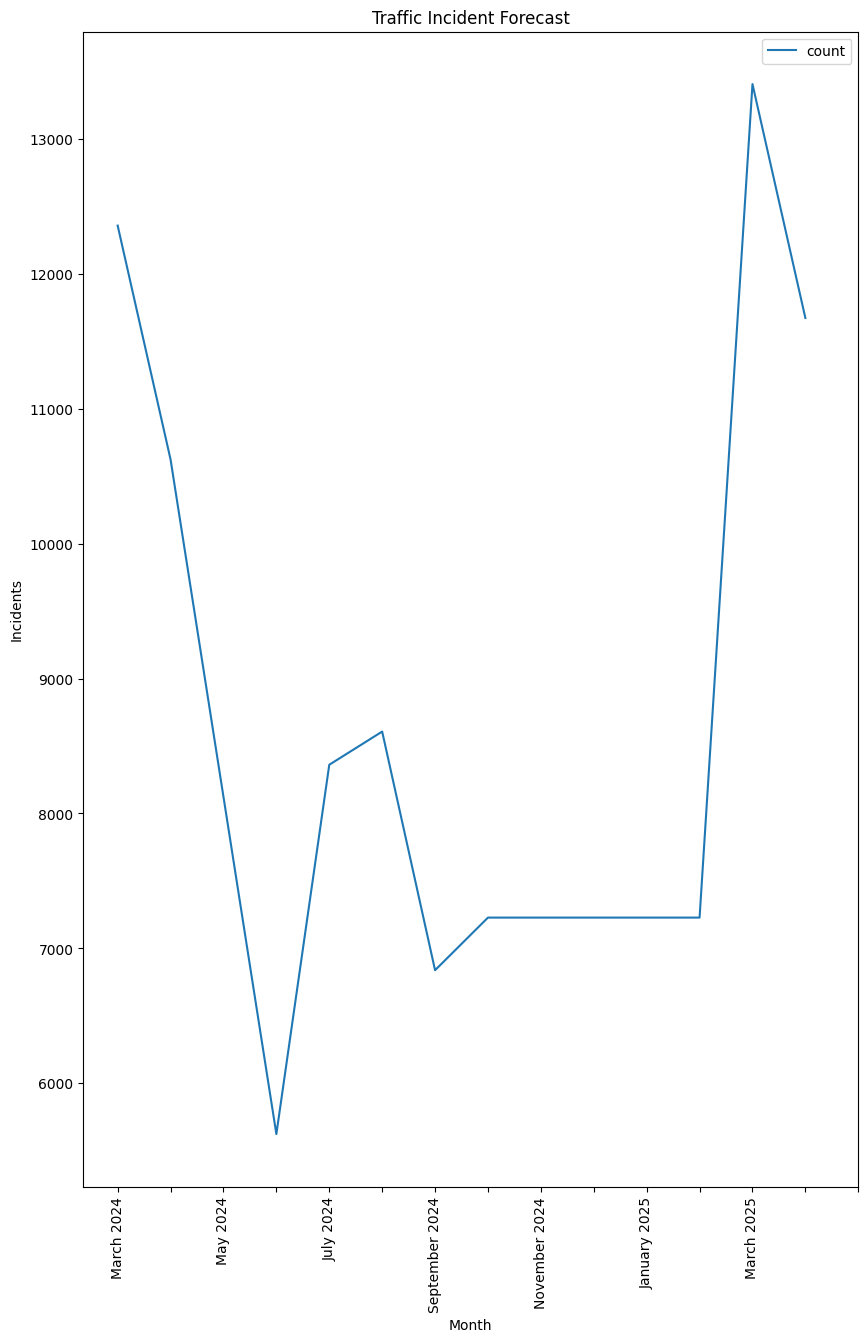

Mean Absolute errorE: 0.0
Mean squared Error: 0.0


In [84]:
df = pd.read_csv("Traffic_Incidents_10.csv",parse_dates=['acci_date'])
df['Month'] = df['acci_date'].dt.month
grouped = df.groupby('Month').size().to_frame('count').reset_index()
grouped = pd.concat([grouped,pd.DataFrame({"Month":[5],'count':[nan]})], ignore_index=True)

grouped = grouped.sort_values(by='Month')
grouped = grouped.interpolate(method='linear')
grouped['Month'] = ['March', 'April', 'May', "June" , "July", "August", "September", "October"]

grouped.reset_index()
#To apply SARIMA the data needs to be stationary 
#Use Dickey-Fuller test 
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
check_stationarity(grouped['count'])

# Fitting the SARIMA model
p, d, q = 1, 1, 1
# 12 month seasons
P, D, Q, s = 1, 1, 1, 12

model = SARIMAX(grouped['count'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

#Set desired forecast period and create the prediction
forecast_periods = 6
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Concatinate the forecast with the grouped dataset
month = 11
for x in forecast_mean:
    new_row = pd.DataFrame({"Month":[month],'count':[x]})
    grouped = pd.concat([grouped,new_row], ignore_index=True)
    month +=1

#Visualize
grouped['Month'] = ["March 2024", 'April 2024', "May 2024","June 2024" , "July 2024", "August 2024", "September 2024", "October 2024",'November 2024','December 2024','January 2025','February 2025','March 2025','April 2025']
grouped.plot(kind='line', x='Month', y='count',figsize=(10, 15))
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.title("Traffic Incident Forecast")
plt.legend()
plt.xticks(range(len(grouped['Month']) + 1), rotation=90)
plt.savefig("Monthly_Traffic_Incident_S12_Forecast.png")
plt.show()

grouped.to_csv("Monthly_Traffic_Incidents_S12_Forecast.csv", encoding='utf-8', index=False)

#Evaluate the model
observed = grouped['count'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'Mean Absolute errorE: {mae}')
print(f'Mean squared Error: {mse}')

#### Creating Forecasts for Upcoming Months With a Seasonality of 7

ADF Statistic: -3.0381105175445473
p-value: 0.03148540178230415
Stationary


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: divide by zero encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


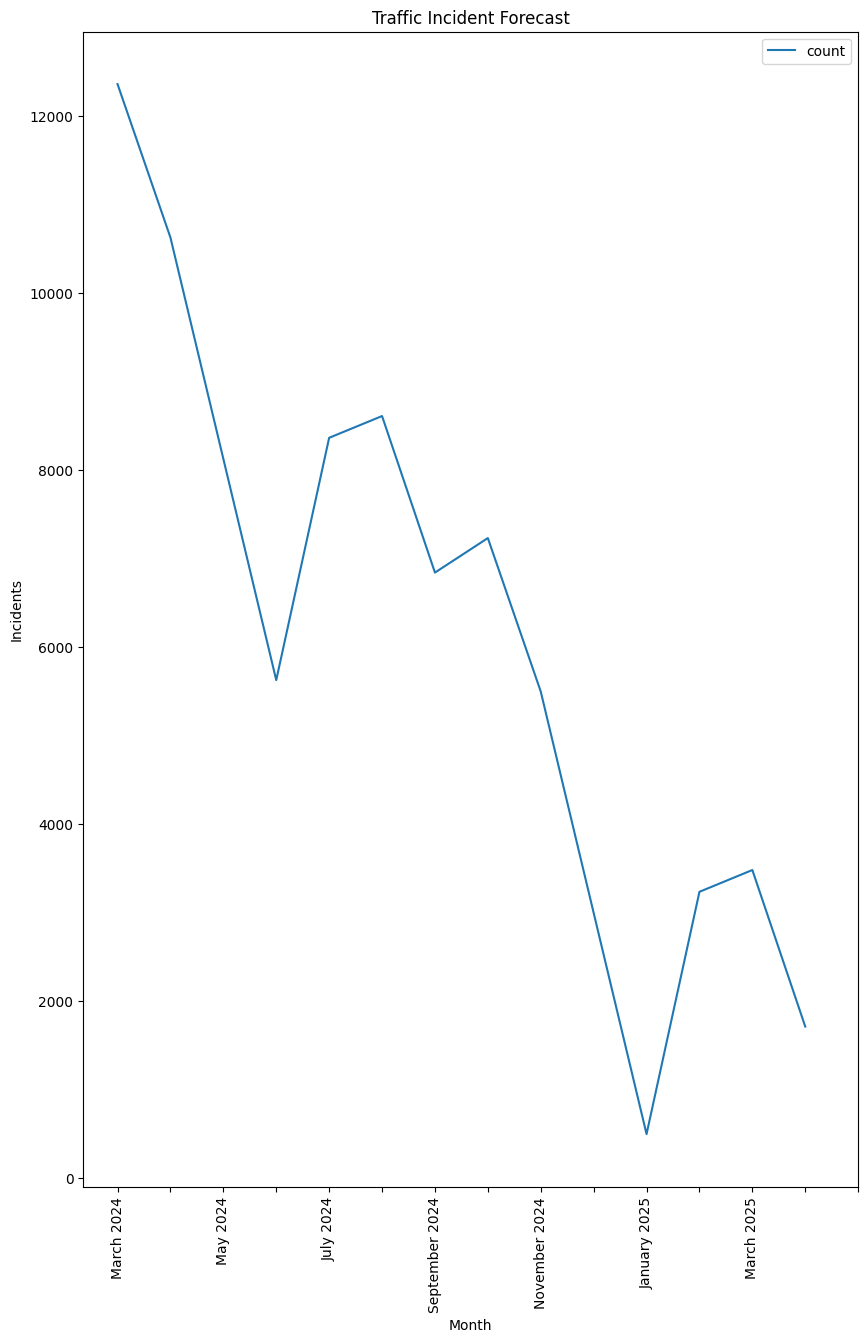

Mean Absolute errorE: 0.0
Mean squared Error: 0.0


In [85]:
df = pd.read_csv("Traffic_Incidents_10.csv",parse_dates=['acci_date'])
df['Month'] = df['acci_date'].dt.month
grouped = df.groupby('Month').size().to_frame('count').reset_index()
grouped = pd.concat([grouped,pd.DataFrame({"Month":[5],'count':[nan]})], ignore_index=True)

grouped = grouped.sort_values(by='Month')
grouped = grouped.interpolate(method='linear')
grouped['Month'] = ['March', 'April', 'May', "June" , "July", "August", "September", "October"]

grouped.reset_index()
#To apply SARIMA the data needs to be stationary 
#Use Dickey-Fuller test 
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
check_stationarity(grouped['count'])

# Fitting the SARIMA model
p, d, q = 1, 1, 1
# 7 month seasons
P, D, Q, s = 1, 1, 1, 7

model = SARIMAX(grouped['count'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

#Set desired forecast period and create the prediction
forecast_periods = 6
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Concatinate the forecast with the grouped dataset
month = 11
for x in forecast_mean:
    new_row = pd.DataFrame({"Month":[month],'count':[x]})
    grouped = pd.concat([grouped,new_row], ignore_index=True)
    month +=1

#Visualize
grouped['Month'] = ["March 2024", 'April 2024', "May 2024","June 2024" , "July 2024", "August 2024", "September 2024", "October 2024",'November 2024','December 2024','January 2025','February 2025','March 2025','April 2025']
grouped.plot(kind='line', x='Month', y='count',figsize=(10, 15))
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.title("Traffic Incident Forecast")
plt.legend()
plt.xticks(range(len(grouped['Month']) + 1), rotation=90)
plt.savefig("Monthly_Traffic_Incident_S7_Forecast.png")
plt.show()

grouped.to_csv("Monthly_Traffic_Incidents_S7_Forecast.csv", encoding='utf-8', index=False)

#Evaluate the model
observed = grouped['count'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'Mean Absolute errorE: {mae}')
print(f'Mean squared Error: {mse}')

#### Creating Forecasts for Upcoming Months With a Seasonality of 5

ADF Statistic: -3.0381105175445473
p-value: 0.03148540178230415
Stationary


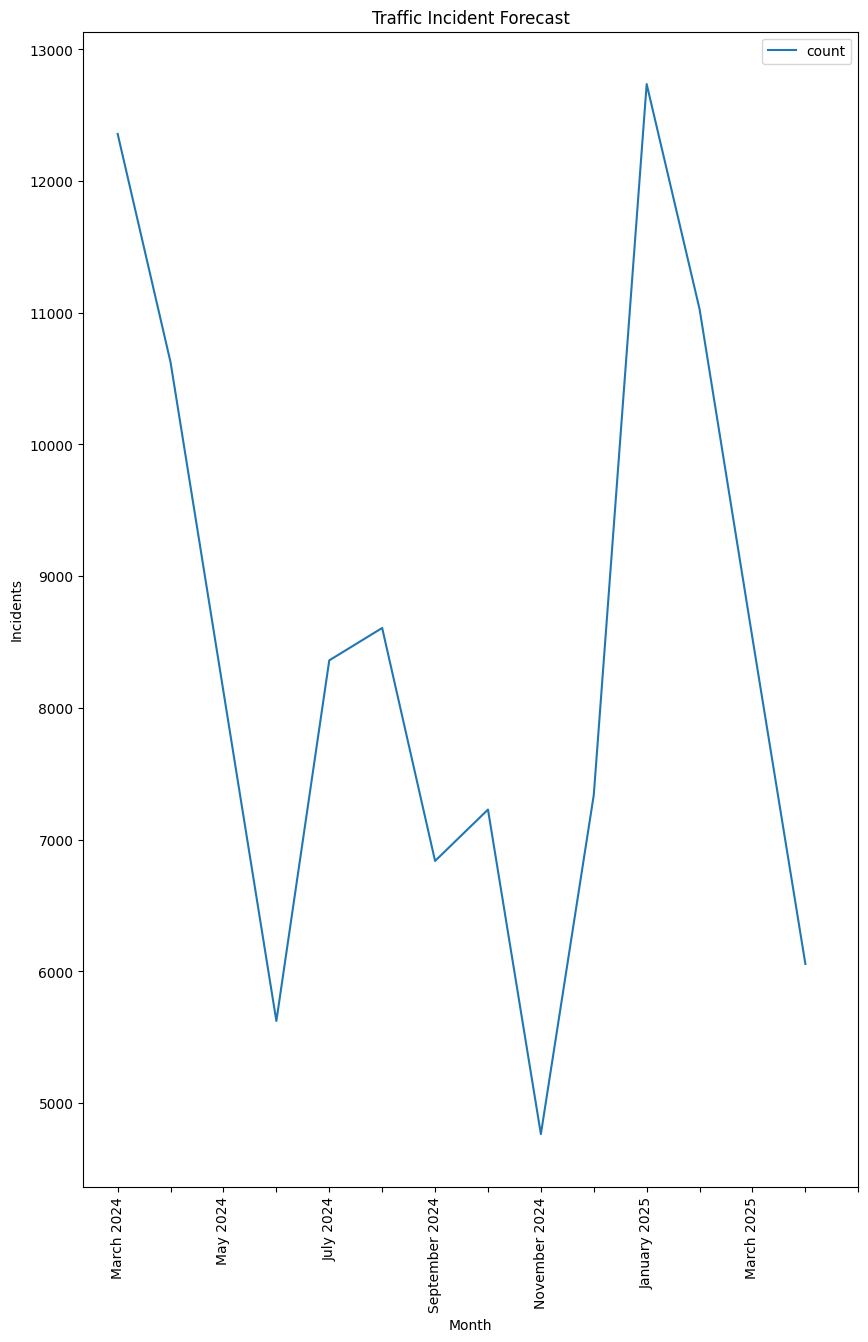

Mean Absolute errorE: 0.0
Mean squared Error: 0.0


In [86]:
df = pd.read_csv("Traffic_Incidents_10.csv",parse_dates=['acci_date'])
df['Month'] = df['acci_date'].dt.month
grouped = df.groupby('Month').size().to_frame('count').reset_index()
grouped = pd.concat([grouped,pd.DataFrame({"Month":[5],'count':[nan]})], ignore_index=True)

grouped = grouped.sort_values(by='Month')
grouped = grouped.interpolate(method='linear')
grouped['Month'] = ['March', 'April', 'May', "June" , "July", "August", "September", "October"]

grouped.reset_index()
#To apply SARIMA the data needs to be stationary 
#Use Dickey-Fuller test 
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
check_stationarity(grouped['count'])

# Fitting the SARIMA model
p, d, q = 1, 1, 1
# 5 month seasons
P, D, Q, s = 1, 1, 1, 5

model = SARIMAX(grouped['count'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

#Set desired forecast period and create the prediction
forecast_periods = 6
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Concatinate the forecast with the grouped dataset
month = 11
for x in forecast_mean:
    new_row = pd.DataFrame({"Month":[month],'count':[x]})
    grouped = pd.concat([grouped,new_row], ignore_index=True)
    month +=1

#Visualize
grouped['Month'] = ["March 2024", 'April 2024', "May 2024","June 2024" , "July 2024", "August 2024", "September 2024", "October 2024",'November 2024','December 2024','January 2025','February 2025','March 2025','April 2025']
grouped.plot(kind='line', x='Month', y='count',figsize=(10, 15))
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.title("Traffic Incident Forecast")
plt.legend()
plt.xticks(range(len(grouped['Month']) + 1), rotation=90)
plt.savefig("Monthly_Traffic_Incident_S5_Forecast.png")
plt.show()

grouped.to_csv("Monthly_Traffic_Incidents_S5_Forecast.csv", encoding='utf-8', index=False)

#Evaluate the model
observed = grouped['count'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'Mean Absolute errorE: {mae}')
print(f'Mean squared Error: {mse}')

### Correlation Analysis

In [87]:
df = pd.read_csv("Traffic_Incidents_10.csv",parse_dates=['acci_date','acci_time'])
df['acci_time'] = df['acci_time'].apply(lambda x: x.timestamp())
df['acci_date'] = df['acci_date'].apply(lambda x: x.timestamp())
df.drop(columns=['acci_desc','acci_severity'],inplace=True)
corr = df.corr(method = 'pearson')
corr

,acci_time,acci_x,acci_y,acci_date
acci_time,1.000000,0.026534,0.010049,-0.004917
acci_x,0.026534,1.000000,0.577530,-0.005427
acci_y,0.010049,0.577530,1.000000,-0.010770
acci_date,-0.004917,-0.005427,-0.010770,1.000000


### Identifying Incidents Hotspots

#### Incidents Involving Animals

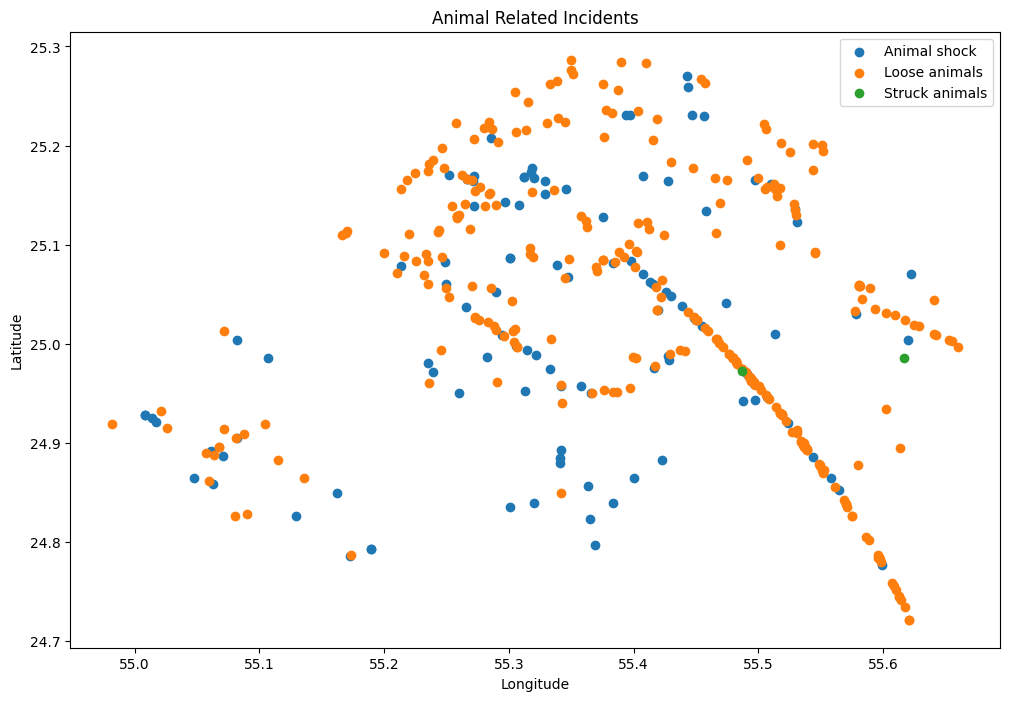

In [125]:
df = pd.read_csv("Traffic_Incidents_10.csv")
df1 = df[df['acci_desc'] == 'Animal shock']
df2 = df[df['acci_desc'] == 'Loose animals on the public road']
df3 = df[df['acci_desc'] == 'An animal was struck']
plt.figure(figsize=(12, 8))
plt.scatter(df1['acci_y'], df1['acci_x'])
plt.scatter(df2['acci_y'], df2['acci_x'])
plt.scatter(df3['acci_y'], df3['acci_x'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Animal Related Incidents")
plt.legend(['Animal shock','Loose animals','Struck animals'])
plt.savefig('Animal_Related_Incidents.png')
plt.show()

#### Incidents Involving Reviews and Drifting

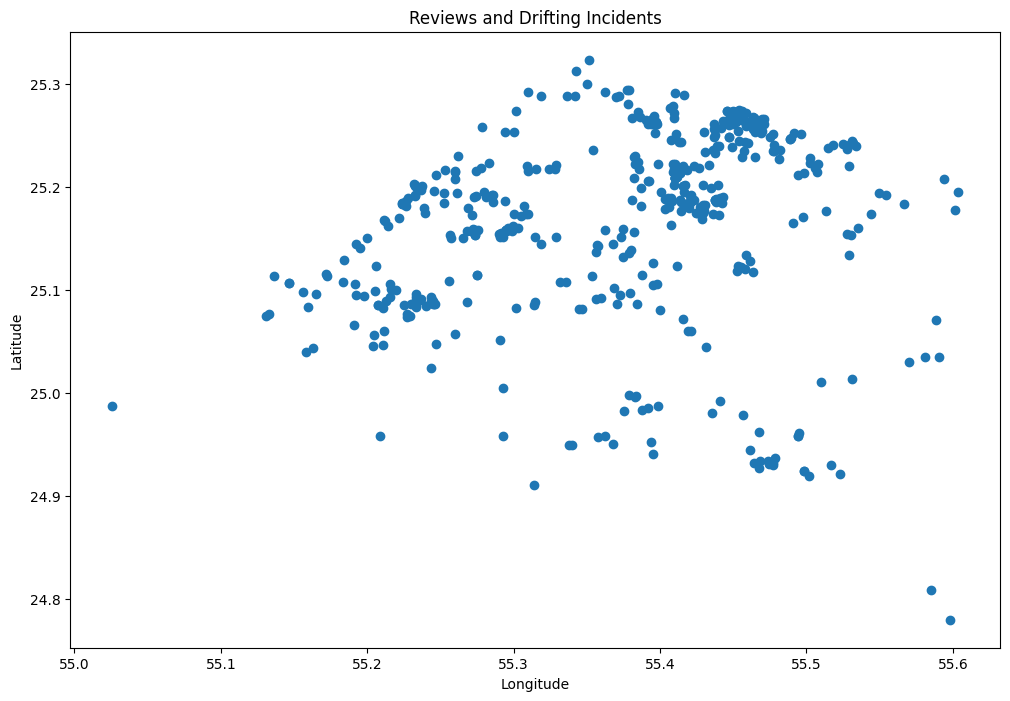

In [124]:
df = pd.read_csv("Traffic_Incidents_10.csv")
df1 = df[df['acci_desc'] == 'Reviews and drifting']

plt.figure(figsize=(12, 8))
plt.scatter(df1['acci_y'], df1['acci_x'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Reviews and Drifting Incidents")
plt.savefig('Reviews_and_Drifting_Incidents.png')
plt.show()

#### Incidents Caused By Traffic Jams

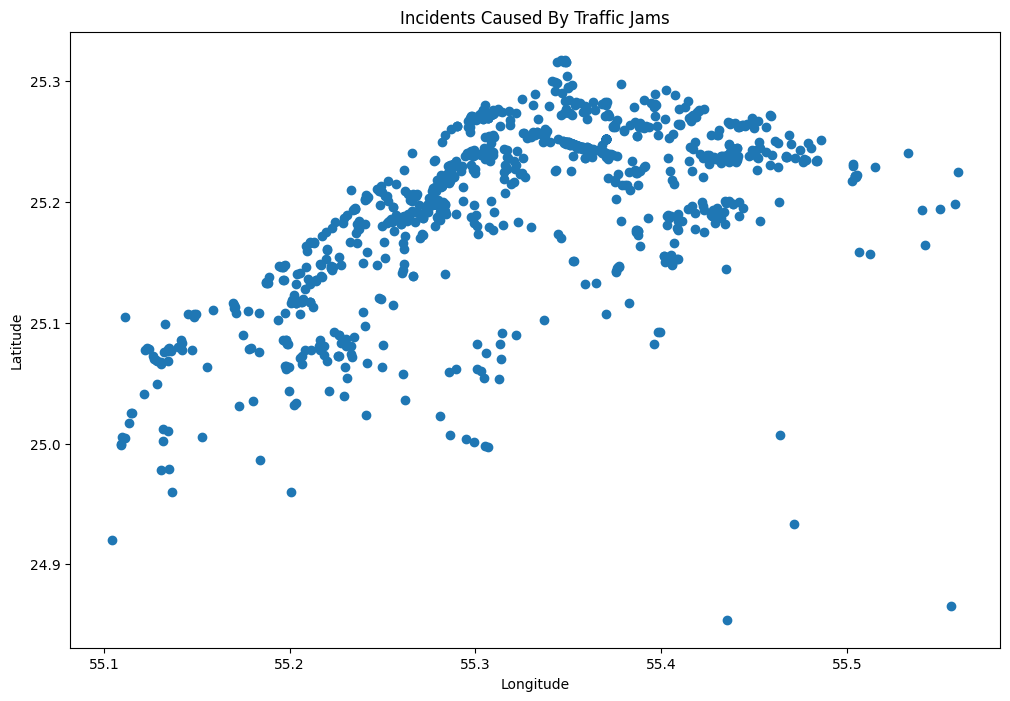

In [123]:
df = pd.read_csv("Traffic_Incidents_10.csv")
df1 = df[df['acci_desc'] == 'Traffic jam']

plt.figure(figsize=(12, 8))
plt.scatter(df1['acci_y'], df1['acci_x'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Incidents Caused By Traffic Jams")
plt.savefig('Incidents_Caused_By_Traffic_Jams.png')
plt.show()